In [13]:
import datetime, json, os
import pandas as pd
import numpy as np 
import tensorflow as tf 
import xgboost as xgb
import sklearn.metrics

from sklearn.model_selection import train_test_split


In [2]:
# set some jupyter magic
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [7]:
no_show_df = pd.read_csv("data/no_show_feature_engineered_no_extreme_locations.csv")
no_show_df.head()

,patientId,appointmentId,gender,scheduledDay,appointmentDay,age,neighborhood,scholarship,hypertension,diabetes,...,appointmentDayDOW__Monday,appointmentDayDOW__Saturday,appointmentDayDOW__Thursday,appointmentDayDOW__Tuesday,appointmentDayDOW__Wednesday,lat,lon,distanceFromCenter,distanceFromCenterLat,distanceFromCenterLon
0,2.987250e+13,5642903,F,2016-04-29 18:38:08,2016-04-29 00:00:00,62,JARDIM DA PENHA,False,True,False,...,0,0,0,0,0,0.490525,-0.169426,-0.198132,-0.280227,-0.201355
1,5.589978e+14,5642503,M,2016-04-29 16:08:27,2016-04-29 00:00:00,56,JARDIM DA PENHA,False,False,False,...,0,0,0,0,0,0.490525,-0.169426,-0.198132,-0.280227,-0.201355
2,4.262962e+12,5642549,F,2016-04-29 16:19:04,2016-04-29 00:00:00,62,MATA DA PRAIA,False,False,False,...,0,0,0,0,0,0.788316,-0.166879,-0.190882,0.089317,-0.199223
3,8.679512e+11,5642828,F,2016-04-29 17:29:31,2016-04-29 00:00:00,8,PONTAL DE CAMBURI,False,False,False,...,0,0,0,0,0,0.341636,-0.170699,-0.201469,-0.464992,-0.200074
4,8.841186e+12,5642494,F,2016-04-29 16:07:23,2016-04-29 00:00:00,56,JARDIM DA PENHA,False,True,True,...,0,0,0,0,0,0.490525,-0.169426,-0.198132,-0.280227,-0.201355


- Change how gender is encoded
- Select features
- Define the baseline model
- Define xgboost model
- Define tensorflow model

In [8]:
# encode the gender as a binary
# NOTE: the gender didn't seem to affect no show by itself, but we're going to keep it and
#       and verify if the model can still use it in conjunction with other variables
no_show_df["isFemale"] = no_show_df["gender"] == "F"

# select the columns that we want to keep
FEATURE_COLS = ["age","scholarship","hypertension","diabetes","alcoholism","handicap","smsSent",
                "daysInAdvance","lat","lon","isFemale","distanceFromCenterLat","scheduledDayHour",
                "otherAppointmentsOnSameDay","previouslyMissed"]
days_of_weeks_cols = [col_name for col_name in no_show_df.columns if "appointmentDayDOW__" in col_name]
FEATURE_COLS += days_of_weeks_cols

# target column
TARGET_COLUMN = "noShow"

# prepare dataset for models
no_show_df["age"] = (no_show_df["age"]-no_show_df["age"].mean())/no_show_df["age"].std()

no_show_df["daysInAdvance"] = (no_show_df["daysInAdvance"]-no_show_df["daysInAdvance"].min())/\
                                (no_show_df["daysInAdvance"].max() - no_show_df["daysInAdvance"].min())

no_show_df["scheduledDayHour"] = (no_show_df["scheduledDayHour"]-no_show_df["scheduledDayHour"].min())/\
                                (no_show_df["scheduledDayHour"].max() - no_show_df["scheduledDayHour"].min())

no_show_df["previouslyMissed"] = (no_show_df["previouslyMissed"]-no_show_df["previouslyMissed"].min())/\
                                (no_show_df["previouslyMissed"].max() - no_show_df["previouslyMissed"].min())

no_show_df["noShow"] = (no_show_df["noShow"])*1

In [9]:
no_show_df[FEATURE_COLS].describe()

,age,daysInAdvance,lat,lon,distanceFromCenterLat,scheduledDayHour,otherAppointmentsOnSameDay,previouslyMissed,appointmentDayDOW__Friday,appointmentDayDOW__Monday,appointmentDayDOW__Saturday,appointmentDayDOW__Thursday,appointmentDayDOW__Tuesday,appointmentDayDOW__Wednesday
count,1.104830e+05,110483.000000,110483.000000,110483.000000,110483.000000,110483.000000,110483.000000,110483.000000,110483.000000,110483.000000,110483.000000,110483.000000,110483.000000,110483.000000
mean,1.476613e-16,0.056905,0.271553,-0.183075,-0.101447,0.318306,0.146611,0.022802,0.172017,0.205552,0.000353,0.156006,0.232009,0.234063
std,1.000000e+00,0.085233,0.602535,0.014870,0.427408,0.214422,0.353719,0.044387,0.377397,0.404106,0.018785,0.362863,0.422116,0.423414
min,-1.604708e+00,0.000000,-0.629942,-0.209515,-0.743123,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-8.258412e-01,0.000000,-0.263382,-0.193611,-0.424844,0.133333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-3.703810e-03,0.022346,0.212190,-0.183430,-0.164289,0.266667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,7.751632e-01,0.083799,0.698255,-0.173670,0.168520,0.466667,0.000000,0.055556,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3.371386e+00,1.000000,1.290402,-0.149047,0.712382,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [10]:
# get training, validation, and test after 
from imblearn.over_sampling import SMOTE, RandomOverSampler

no_show_df = no_show_df.sort_values(['appointmentDay','scheduledDay'])

X = no_show_df[FEATURE_COLS].values
y = no_show_df[TARGET_COLUMN].values

SEQUENTIAL_SPLIT = False
# get train = 60%, validation = 20%, test = 20%
if not SEQUENTIAL_SPLIT:
    train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=0.2,random_state=127) # split between train and test
    train_X, val_X, train_y, val_y = train_test_split(train_X,train_y,train_size=0.75,random_state=127) # split train to get validation

else:
    train_X = X[:int(X.shape[0]*(0.8))]
    train_y = y[:int(y.shape[0]*(0.8))]
    test_X = X[int(X.shape[0]*(0.8)):]
    test_y = y[int(y.shape[0]*(0.8)):]

    val_X = train_X[int(train_X.shape[0]*(0.75)):]
    val_y = train_y[int(train_y.shape[0]*(0.75)):]

    # remove validation from training set
    train_X = train_X[:int(train_X.shape[0]*(0.75))]
    train_y = train_y[:int(train_y.shape[0]*(0.75))]

    assert len(train_X) + len(val_X) + len(test_X) == len(X), "Something went wrong while splitting up the sets"
# using RandomOverSampler for generating synthetic samples to help with class imbalance
oversample = RandomOverSampler(random_state=127)
train_X, train_y = oversample.fit_resample(train_X, train_y)


train_X = train_X.astype(np.float32)
val_X = val_X.astype(np.float32)
test_X = test_X.astype(np.float32)
train_y = train_y.astype(np.int8)
val_y = val_y.astype(np.int8)
test_y = test_y.astype(np.int8)

## What does success look like?

### Selecting some metrics
As we assessed in the data exploration piece, we are facing a binary classification problem with an imbalanced dataset. For this reason, accuracy is not a good candidate to assess the performance of the models that we will build. Nonetheless, we will keep track of it as a vanity metric, to help understand how many misclassified cases the hospital will face (and, let's be honest, who isn't curious to know of how accurate the model is - regardless of it being a good metric or not?)

The metrics that will be considered to assess which of the three proposed models is best at predicting no shows are:
* **AUC ROC** - The area under the receiver operating characteristic curve considers the True Positive Rate (TPR = True Positives/(True Positives + False Negatives)) and the False Positive Rate (FPR = False Positives/(False Positives + True Negatives)). It gives us an indication of how good the model is at **predicting the positives as positive and negatives as negative**. 
* **Precision** - Represents the percentage of the values that the model flags as positive that are actually positive. 
* **Recall** - Represents the percentage of actually positive values that the model classify correctly.

### Interpreting the metrics

To understand how to interpret the metrics in the context of hospitals no-show, let's imagine for a moment that the hospitals will take our final model (chosen between the three here proposed) and set up a team which is going to be in charge of chasing the patients flagged by the model as potential no-shows.

#### Precision
In this case, precision is going to give us an indication of **wasted resources** when the hospitals follow the model recommendations. For example, a model with a 90% precision will mean that 9 patients out of 10 flagged by the model were in fact not going to show their appointments. This allows our hypothetical team to dedicate more resources "chasing" them, as they are extremely likely to actually result in no-shows. On contrary, a model scoring 30% in precision would mean that only 3 of those 10 patients flagged by the model were going to not show up. For our imaginary team, this means that in 7 cases out of 10 their effort was unnecessary (as the patients they were chasing were going to show up anyway).

#### Recall
Sticking with our imaginary 'no-show'-busters team, recall would represent their **peace of mind**. We can imagine that the model that we are building is going to be only one of the tools at the team disposal (e.g. they might want to decide to invest in a communication campaign around no-show awareness), and that the hospital management will evaluate the performance of the team on KPIs such as _"Reduction in year-on-year number of no-shows in the hospitals of Vitoria"_. Recall measures how many actual positives where identified by the model and, as a consequence, how many cases a team which blindly relies on the model is going to miss. For example, a model with a recall score of 30% will flag on average only 3 non-showing patients out of 10 - the remaining 7 will be flagges as showing and would not be surfaced to the attention of our busy team. 

#### AUC ROC
This concept is a bit less intuitive, as the AUC ROC metrics evaluates the true positive and false positive rate at every possible threshold. While this sounds complicated at first, it becomes much simpler to graps with an understanding of how out machine learning estimators work. For a classification task, the models that we are using in this experiment do not output a yes/no answer, but rather a number between 0 and 1 which can be intuitively interpreted as the probability of a given appointment to result in a show or no-show. This means that we can define a threshold of what we consider to be a "yes" and what a "no" - for the standard precision and recall metrics, this threshold is set at 0.5: lower than that, the patient shows up, higher than 0.5 the patient will not show up. **Therefore, what is defined as a true/false positive and true/false negative depends on this threshold** and the AUC ROC metric uses some magic (actually just math) to calculate how these values change at each threshold value between 0 and 1. Intuitively, the AUC ROC can be interpreted by **how good is the model at ranking the probabilities of actual positives higher than the probabilities of actual negatives**.

#### TL;DR
* A high precision means that we'll be focusing our efforts where they are actually needed
* A high recall means that we don't have to worry about the model missing non-showing patients.

## Baseline model

As reported in publications studying hospitals no-shows, most clinics currently do not have any way to identify patients that are likely not to show up to appointments (Srinivas, Sharan, and A. Ravi Ravindran, 2018). For this reason, and given the class imbalance of the dataset, we can assume they naively decide on either assuming everyone will show up, or that they won't. 

From an accuracy perspective, the baseline model assuming that every patient always shows up gives the highest value (as most patients actually show up). In practice, even if hospitals cannot predict if a given patient will show up or not, they are likely to know a percentage of no-shows per day and use it to overbook appointments. 

When we focus on designing and implementing tools and processes to reduce no-shows (e.g. SMS reminders), we can assume that hospitals will consider every patient as potential no-show. (NOTE: in the case of SMS, we know that the hospitals do not send them to everyone. However, we will assume this to be unrelated to the way they manage no-shows, and to be related to other additional factors).

In [39]:
def evaluate_baseline_model(ground_truth,naive_choice=1):
    """Compute the metrics for the baseline model"""
    pred_labels = [naive_choice]*len(ground_truth) 
    results = {"accuracy": sklearn.metrics.accuracy_score(ground_truth,pred_labels),
             "precision": sklearn.metrics.precision_score(ground_truth,pred_labels),
             "recall": sklearn.metrics.recall_score(ground_truth,pred_labels),
             "AUC_ROC": sklearn.metrics.roc_auc_score(ground_truth,pred_labels)}
    for metric, value in results.items():
        print(metric,"-",value)

In [40]:
evaluate_baseline_model(test_y)

accuracy - 0.20061546816309905
precision - 0.20061546816309905
recall - 1.0
AUC_ROC - 0.5


## The Wide and Deep model

The wide and Deep model has been defined in the file 'models/deep_and_wide.py' using Tensorflow Keras Subclassing API. This model architecture was first designed by a team of Google researchers in the publication [Wide & Deep Learning for Recommender Systems](https://arxiv.org/abs/1606.07792).

The model is named "deep and wide" after its architecture. It is made of two parts: a "deep" one, containing one or more dense hidden layers, which focuses on generalizing learnings in an abstract manner (e.g. birds can fly). The "wide" component simply connects the input straight to the output layer, skipping the hidden layers. This component focuses on memorization (e.g. penguins don't fly). The two components are then concatenated together before the output layer, which has 1 neuron and a sigmoid activation function to squeeze the output value of the neuron between 0 and 1. The model uses an Adam optimizer.

The tuning of the hyperparameters has been performed with an [Asyncronous Hyperband](https://openreview.net/forum?id=S1Y7OOlRZ) algorithm supported by an hyperparameters search algorithm based on Tree-structured Parzen Estimators. In this notebook, it is only reported the final configuration of the network for brevity. The hyperparameter tuning code and all of its dependencies can be found in the file 'models/nn_hparams_tuning.py'. The metric being considered in this optimization process was the validation AUC ROC.


In [1]:
from models.deep_and_wide import DeepAndWide

!pygmentize models/deep_and_wide.py

import tensorflow as tf
from tensorflow import keras
from kerastuner.tuners import Hyperband


class DeepAndWide(keras.Model):

    def __init__(self,hidden_dim=64,activation="relu",dropout=0.3,n_hidden_layers=2,regularization=0.001,**kwargs):
        super().__init__(**kwargs)
        self.hidden = keras.layers.Dense(hidden_dim,activation=activation, 
                                        kernel_regularizer=keras.regularizers.l2(regularization),name="Hidden")
        self.output_layer = keras.layers.Dense(1,activation=tf.nn.sigmoid)
        self.dropout = tf.keras.layers.Dropout(dropout)
        self.n_hidden_layers = n_hidden_layers
    
    def call(self,inputs,training=False):
        inputs
        for _ in range(self.n_hidden_layers):
            x2 = self.hidden(inputs)
            x2 = self.dropout(x2, training=training)
        x = keras.layers.concatenate([inputs,x2])
        output = self.output_layer(x)
        return output


In [31]:
from models.deep_and_wide import DeepAndWide
def make_nn_model(config):
    """Creates and compiles an instance of the model with the provided hyperparameters"""
    model = DeepAndWide(hidden_dim=config["hidden_dim"],
                        activation=config["activation"],
                        dropout=0.3,
                        n_hidden_layers=config["n_hidden_layers"],
                        regularization=config["regularization"])
    model.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate = config["lr"]),
    metrics=["accuracy",tf.keras.metrics.AUC(curve="ROC"),tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
    
    return model

In [32]:
# train the model with the best configuration
epochs = 60

with open("models/dnw_params.json","r") as f:
    best_config_nn = json.load(f)
print("Best configuration for the Deep and Wide network:")
print(best_config_nn)

model = make_nn_model(best_config_nn)

history = model.fit(
            train_X,
            train_y,
            epochs=epochs,
            verbose=2,
            validation_data=(val_X, val_y),
            callbacks=[tf.keras.callbacks.ModelCheckpoint("./models/model_checkpoints/mymodel_{epoch}.h5"),
                       tf.keras.callbacks.TensorBoard(log_dir="./models/logs", histogram_freq=1)])

Best configuration for the Deep and Wide network:
{'activation': 'relu', 'hidden_dim': 45, 'iterations': 100, 'lr': 0.2975559558171681, 'n_hidden_layers': 1, 'regularization': 0.05059536754175111, 'threads': 2}
Train on 105678 samples, validate on 22097 samples
Epoch 1/60
105678/105678 - 9s - loss: 0.3462 - accuracy: 0.9115 - auc: 0.9415 - precision: 0.8836 - recall: 0.9479 - val_loss: 0.4153 - val_accuracy: 0.8972 - val_auc: 0.9451 - val_precision: 0.6620 - val_recall: 0.9946
Epoch 2/60
105678/105678 - 6s - loss: 0.3284 - accuracy: 0.9210 - auc: 0.9442 - precision: 0.8903 - recall: 0.9602 - val_loss: 0.4069 - val_accuracy: 0.9007 - val_auc: 0.9453 - val_precision: 0.6777 - val_recall: 0.9618
Epoch 3/60
105678/105678 - 7s - loss: 0.3288 - accuracy: 0.9215 - auc: 0.9446 - precision: 0.8909 - recall: 0.9605 - val_loss: 0.4113 - val_accuracy: 0.8962 - val_auc: 0.9479 - val_precision: 0.6614 - val_recall: 0.9876
Epoch 4/60
105678/105678 - 7s - loss: 0.3269 - accuracy: 0.9210 - auc: 0.9447 

Epoch 37/60
105678/105678 - 6s - loss: 0.3285 - accuracy: 0.9212 - auc: 0.9444 - precision: 0.8909 - recall: 0.9600 - val_loss: 0.3754 - val_accuracy: 0.9002 - val_auc: 0.9457 - val_precision: 0.6751 - val_recall: 0.9672
Epoch 38/60
105678/105678 - 6s - loss: 0.3248 - accuracy: 0.9225 - auc: 0.9447 - precision: 0.8912 - recall: 0.9625 - val_loss: 0.3503 - val_accuracy: 0.9030 - val_auc: 0.9486 - val_precision: 0.6961 - val_recall: 0.9155
Epoch 39/60
105678/105678 - 6s - loss: 0.3263 - accuracy: 0.9216 - auc: 0.9449 - precision: 0.8912 - recall: 0.9605 - val_loss: 0.4426 - val_accuracy: 0.8959 - val_auc: 0.9487 - val_precision: 0.6582 - val_recall: 0.9986
Epoch 40/60
105678/105678 - 6s - loss: 0.3267 - accuracy: 0.9212 - auc: 0.9450 - precision: 0.8910 - recall: 0.9599 - val_loss: 0.3727 - val_accuracy: 0.8995 - val_auc: 0.9462 - val_precision: 0.6728 - val_recall: 0.9697
Epoch 41/60
105678/105678 - 6s - loss: 0.3271 - accuracy: 0.9219 - auc: 0.9448 - precision: 0.8911 - recall: 0.9612 

In [34]:
# load model at epoch 58
saved_model = make_nn_model(best_config_nn)
saved_model.load_weights("./models/model_checkpoints/mymodel_58")

In [35]:
# check how the model is performing on training and test data
train_results = saved_model.evaluate(train_X,train_y,verbose=0)
train_metrics = list(zip(saved_model.metrics_names,train_results))
test_results = saved_model.evaluate(test_X,test_y,verbose=0)
test_metrics = list(zip(saved_model.metrics_names,test_results))

print("Training metrics:")
for metric in train_metrics:
    print(metric[0]+":",metric[1])
print("-------------")
print("Test metrics:")
for metric in test_metrics:
    print(metric[0]+":",metric[1])

Training metrics:
loss: 0.3158055896661029
accuracy: 0.93259716
auc_1: 0.946904
precision_1: 0.89056146
recall_1: 0.9864116
-------------
Test metrics:
loss: 0.40084671764323715
accuracy: 0.89994115
auc_1: 0.9477904
precision_1: 0.6708705
recall_1: 0.98398376


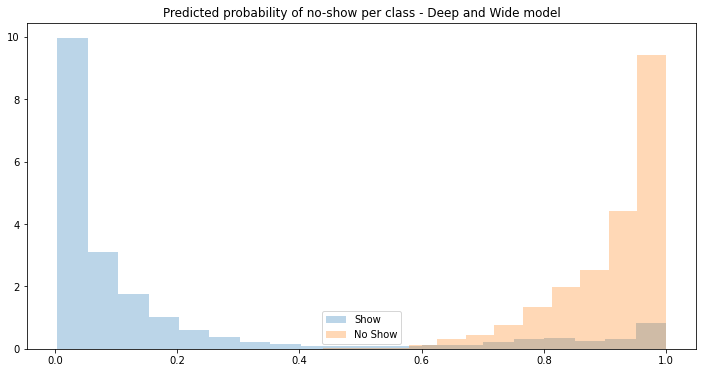

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
# plot the distribution of raw probabilities
predictions_nn = model.predict(test_X)
predictions_nn_df = pd.DataFrame({"prediction":predictions_nn.squeeze(),"ground_truth":test_y.squeeze()})

fig, ax = plt.subplots(figsize=(12, 6))
#sns.kdeplot(predictions_nn_df.loc[predictions_nn_df.ground_truth == 0].prediction, shade=1, color='darkturquoise', label = "Show")
#sns.kdeplot(predictions_nn_df.loc[predictions_nn_df.ground_truth == 1].prediction, shade=1, color='red', label = "No Show")
ax.hist(x="prediction", data = predictions_nn_df.loc[predictions_nn_df.ground_truth == 0], 
        bins=20, density=True, label='Show',alpha=0.3)
ax.hist(x="prediction", data = predictions_nn_df.loc[predictions_nn_df.ground_truth == 1], 
        bins=20, density=True, label='No Show', alpha=0.3)
ax.set_title("Predicted probability of no-show per class - Deep and Wide model")
ax.legend()
plt.show()

In [75]:
print(sklearn.metrics.classification_report(test_y,np.rint(predictions_nn.squeeze()).astype(np.int8)))

              precision    recall  f1-score   support

           0       1.00      0.86      0.93     17664
           1       0.65      1.00      0.79      4433

    accuracy                           0.89     22097
   macro avg       0.82      0.93      0.86     22097
weighted avg       0.93      0.89      0.90     22097



In [72]:
test_y

array([1, 0, 0, ..., 0, 0, 0], dtype=int8)

#### Comment

The Deep and Wide model shows good performances with an AUC_ROC score which remains stable when moving from the training set to the test set.

Overall, the model seems to have found a generalized solution to the problem. Even if a decrease in precision is preminent, this can be explained considering that the test set has not been oversampled to mimick as much as possible real operationals conditions (the training set therefore contains much more no-shows compared to the test set). 

Moving to the "business" metrics, the recall is in both training and test set above 98%, which is a great result. This means that the model is able to identify most of the patients who are not going to show up to medical appointments. 
The test precision is roughly 67%, which means our hypothetic no-show team will still have to deal with some false positives. However, the number of unnecessary interventions following the model is getting closer to 3 out of 10, which is a significant improvement over the 8 out of 10 (20% precision score) of the baseline model. 

## XGBoost

In addition to the model built above, I trained an xgboost model to have a comparison with a different type of machine learning model that could potentially solve the problem. XGBoost is the go-to algorithm for most machine learning challenges and it implements gradient boosted decision trees. 

In order to have a fair comparison with the Deep and Wide network, a hyperparameter tuning job has been performed with the same objective of maximizing validation AUC ROC. The implementation can be found in the file 'models/xgboost_hparams_tuning.py' and it's not reported here for brevity. 

In [43]:
# load the best hyperparameters configuration found during the tuning
with open("models/xgboost_params.json","r") as f:
    best_config_xgboost = json.load(f)
print("Best configuration for the XGBoost model:")
print(best_config_xgboost)


Best configuration for the XGBoost model:
{'verbosity': 0, 'num_threads': 2, 'objective': 'binary:logistic', 'booster': 'gbtree', 'eval_metric': ['auc', 'ams@0', 'logloss'], 'colsample_bytree': 0.6449230140228082, 'eta': 0.32949882641198586, 'gamma': 0.17591537269244814, 'grow_policy': 'depthwise', 'max_depth': 6, 'min_child_weight': 1}


In [44]:
# prepare the data and train xgboost
train_set = xgb.DMatrix(train_X, label=train_y)
val_set = xgb.DMatrix(val_X, label=val_y)
test_set = xgb.DMatrix(test_X, label=test_y)

bst = xgb.train(best_config_xgboost, train_set, evals=[(val_set, "eval")])

[0]	eval-auc:0.96754	eval-ams@0:84.34995	eval-logloss:0.47485
[1]	eval-auc:0.96645	eval-ams@0:84.62337	eval-logloss:0.37265
[2]	eval-auc:0.96728	eval-ams@0:84.74600	eval-logloss:0.30852
[3]	eval-auc:0.96714	eval-ams@0:84.66460	eval-logloss:0.27378
[4]	eval-auc:0.96835	eval-ams@0:84.61449	eval-logloss:0.24851
[5]	eval-auc:0.96863	eval-ams@0:84.86166	eval-logloss:0.23252
[6]	eval-auc:0.96835	eval-ams@0:84.95834	eval-logloss:0.22459
[7]	eval-auc:0.96801	eval-ams@0:84.99585	eval-logloss:0.21952
[8]	eval-auc:0.96881	eval-ams@0:84.82929	eval-logloss:0.21350
[9]	eval-auc:0.96913	eval-ams@0:84.80513	eval-logloss:0.21064


In [45]:
def evaluate_model(bst,set,ground_truth):
    """Compute the metrics for an xgboost model"""
    preds = bst.predict(set)
    pred_labels = np.rint(preds)
    results = {"accuracy": sklearn.metrics.accuracy_score(ground_truth,pred_labels),
             "precision": sklearn.metrics.precision_score(ground_truth,pred_labels),
             "recall": sklearn.metrics.recall_score(ground_truth,pred_labels),
             "AUC_ROC": sklearn.metrics.roc_auc_score(ground_truth,pred_labels)}
    for metric, value in results.items():
        print(metric,"-",value)

In [46]:
print("Training set performance:")
evaluate_model(bst,train_set,train_y)
print("\nValidation set performance:")
evaluate_model(bst,val_set,val_y)
print("\nTest set performance:")
evaluate_model(bst,test_set,test_y)

Training set performance:
accuracy - 0.9421450065292681
precision - 0.8998305693895364
recall - 0.9950604667007324
AUC_ROC - 0.9421450065292682

Validation set performance:
accuracy - 0.9087206408109698
precision - 0.6889411764705883
recall - 0.9923181201988251
AUC_ROC - 0.9400501811451938

Test set performance:
accuracy - 0.9107118613386432
precision - 0.6943127962085308
recall - 0.9914279269117979
AUC_ROC - 0.940941544977638


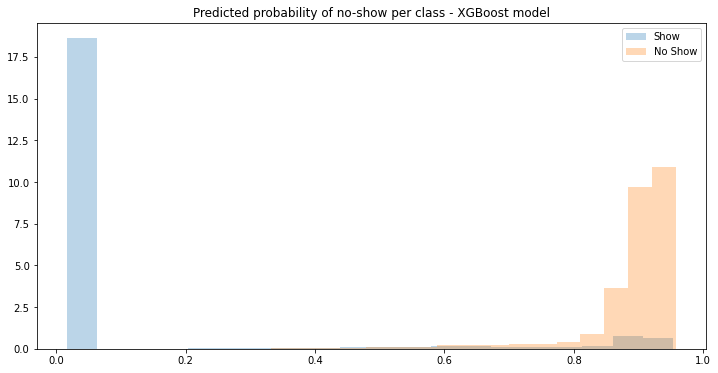

In [66]:
predictions_xgb = bst.predict(test_set)
predictions_xgb_df = pd.DataFrame({"prediction":predictions_xgb.squeeze(),"ground_truth":test_y.squeeze()})

fig, ax = plt.subplots(figsize=(12, 6))
#sns.kdeplot(predictions_xgb_df.loc[predictions_xgb_df.ground_truth == 1].prediction, shade=1, color='red', label = "No Show")
#sns.kdeplot(predictions_xgb_df.loc[predictions_xgb_df.ground_truth == 0].prediction, shade=1, color='darkturquoise', label = "Show")
ax.hist(x="prediction", data = predictions_xgb_df.loc[predictions_xgb_df.ground_truth == 0], 
        bins=20, density=True, label='Show',alpha=0.3)
ax.hist(x="prediction", data = predictions_xgb_df.loc[predictions_xgb_df.ground_truth == 1], 
        bins=20, density=True, label='No Show', alpha=0.3)
ax.set_title("Predicted probability of no-show per class - XGBoost model")
ax.legend()
plt.show()

In [78]:
xgb_pred_labels = np.rint(predictions_xgb)
print(sklearn.metrics.classification_report(test_y,xgb_pred_labels))

              precision    recall  f1-score   support

           0       1.00      0.89      0.94     17664
           1       0.69      0.99      0.82      4433

    accuracy                           0.91     22097
   macro avg       0.85      0.94      0.88     22097
weighted avg       0.94      0.91      0.92     22097



#### Comment
Also this XGBoost implementation gives some really good results. The precision and recall values are comparable (but higher) with the Deep and Wide network, therefore the same considerations apply. The AUC ROC is higher for the Deep and Wide network (0.948 vs 0.941), although having loaded the model checkpoints for a different epoch could have changed the outcome of this comparison for all three metrics considered.

## Discussion

A machine learning approach brings clear advantages in reducing the number of no-shows to medical appointments. The recall score close to 100% of the two models explored in this notebook is comparable to the only advantage of the baseline model: don't miss any potential no-show. 

At the same time, a machine learning powered approach can cut through the clutter, reducing the number of cases that are currently wrongly considered potential no-show by over 60%. The dataset covers slightly more than a month and contains over 110k appointments. The possibility of reducing the number of appointments to analyze and act upon could make the problem more manageable and more rewarding for the people involved. 

Possibility for people working on reducing no-shows to interpret the model.

Sigmoid shape gives the possibility to move the threshold in more seamless way. (more ranking)

## Limitations and future steps

### Limitations
* The dataset only convered a period of slightly over than a month. It would be interesting to repeat the analysis with a longer timeframe
* Most of the features are orthogonal to the target variable: what other features could be better predictors of medical appointment no-shows?
* Certain variables present issues or unclarified points, for example:
    * No SMS were sent for the equivalent of roughly for one third of the available timeframe. It is not clear what might have happened there. Not enough data is available in the dataset to disregard that portion of data.
    * There is no indication of the 